In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from collections import Counter
warnings.filterwarnings('ignore')
plt.rcParams.update({'figure.max_open_warning': 0})


In [ ]:
# Load dataset (assumes the file 'Netflix Dataset.csv' is in the working directory)
import os
file_path = '/content/Netflix Dataset.csv'
if not os.path.exists(file_path):
    raise FileNotFoundError(f"Dataset file not found at {file_path}. Please upload the CSV to the notebook's working directory.")

df = pd.read_csv(file_path)
print('Loaded dataset with shape:', df.shape)
print('\nOriginal columns:')
print(df.columns.tolist())

# Show a quick preview
df.head().copy()

Loaded dataset with shape: (7789, 11)

Original columns:
['Show_Id', 'Category', 'Title', 'Director', 'Cast', 'Country', 'Release_Date', 'Rating', 'Duration', 'Type', 'Description']


,Show_Id,Category,Title,Director,Cast,Country,Release_Date,Rating,Duration,Type,Description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,07:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",PG-13,123 min,Dramas,A brilliant group of students become card-coun...


In [ ]:
# Normalize column names to lowercase and strip spaces — keep original mapping for reference
orig_cols = df.columns.tolist()
col_map = {c: c.strip().lower().replace(' ', '_') for c in orig_cols}
df.rename(columns=col_map, inplace=True)
print('Normalized columns:')
print(df.columns.tolist())


Normalized columns:
['show_id', 'category', 'title', 'director', 'cast', 'country', 'release_date', 'rating', 'duration', 'type', 'description']


In [ ]:
# Map common expected column names (flexible)
expected = {
    'title': ['title'],
    'type': ['type'],
    'director': ['director'],
    'cast': ['cast', 'cast_'],
    'country': ['country', 'countries'],
    'date_added': ['date_added', 'release_date', 'release_date_'],
    'rating': ['rating', 'ratings'],
    'duration': ['duration'],
    'listed_in': ['listed_in', 'genre', 'genres']
}

# Create a reverse lookup to find the actual column name present
found = {}
for key, variants in expected.items():
    for v in variants:
        if v in df.columns:
            found[key] = v
            break

print('Found column mapping:')
for k, v in found.items():
    print(f" - {k}: {v}")

# If date column not found, we'll attempt to infer a date column
if 'date_added' not in found:
    # look for any column name containing 'date'
    for c in df.columns:
        if 'date' in c:
            found['date_added'] = c
            print(f"Inferred date column as: {c}")
            break

# If essential columns are missing, inform user but continue
essential_checks = ['title', 'type']
for ec in essential_checks:
    if ec not in found:
        print(f"Warning: could not find expected column for '{ec}'. Some analyses may be limited.")


Found column mapping:
 - title: title
 - type: type
 - director: director
 - cast: cast
 - country: country
 - date_added: release_date
 - rating: rating
 - duration: duration


In [ ]:
# Create standard column names in dataframe for consistent downstream code
for std_col, actual in found.items():
    df[std_col] = df[actual]

# If some standard columns missing, create them with NaNs so code won't break
for std_col in ['title','type','director','cast','country','date_added','rating','duration','listed_in']:
    if std_col not in df.columns:
        df[std_col] = np.nan

# Quick info
print('Final working columns available:')
print([c for c in ['title','type','director','cast','country','date_added','rating','duration','listed_in'] if c in df.columns])
print('\nNull counts for these columns:')
print(df[['title','type','country','date_added','listed_in']].isnull().sum())


Final working columns available:
['title', 'type', 'director', 'cast', 'country', 'date_added', 'rating', 'duration', 'listed_in']

Null counts for these columns:
title            0
type             0
country        507
date_added      10
listed_in     7789
dtype: int64


In [ ]:
# Fill textual columns
for col in ['director','cast','country','rating','listed_in','duration']:
    if col in df.columns:
        df[col] = df[col].fillna('Unknown')

# Normalize country: if multiple countries separated by comma, take the first
if 'country' in df.columns:
    df['country'] = df['country'].astype(str).apply(lambda x: x.split(',')[0].strip() if x.strip() and x.lower()!='unknown' else 'Unknown')

# Parse date column robustly
if df['date_added'].isnull().all():
    print('Date column is entirely empty or not found. Year-based analyses will be skipped.')
else:
    # Try to parse with to_datetime with errors='coerce'
    df['date_added_parsed'] = pd.to_datetime(df['date_added'], errors='coerce')
    # If parsing produced NaT for many rows, try alternative parsing (common formats)
    num_parsed = df['date_added_parsed'].notnull().sum()
    print(f'Parsed {num_parsed} rows into date_added_parsed.')
    # Fill a year_added column
    df['year_added'] = df['date_added_parsed'].dt.year
    df['month_added'] = df['date_added_parsed'].dt.month

# Safe genre parsing function
def extract_genres(cell):
    if pd.isna(cell) or str(cell).strip().lower()=='unknown':
        return []
    parts = [p.strip() for p in str(cell).split(',') if p.strip()]
    return parts

# Build a column of genre lists
df['genre_list'] = df['listed_in'].apply(extract_genres)

# Add a helper column for first_genre (for simple grouping)
df['first_genre'] = df['genre_list'].apply(lambda x: x[0] if x else 'Unknown')

print('\nCleaning complete. Sample:')
df[['title','type','country','date_added','date_added_parsed','year_added','first_genre']].head()

Parsed 7691 rows into date_added_parsed.

Cleaning complete. Sample:


,title,type,country,date_added,date_added_parsed,year_added,first_genre
0,3%,"International TV Shows, TV Dramas, TV Sci-Fi &...",Brazil,"August 14, 2020",2020-08-14,2020.0,Unknown
1,07:19,"Dramas, International Movies",Mexico,"December 23, 2016",2016-12-23,2016.0,Unknown
2,23:59,"Horror Movies, International Movies",Singapore,"December 20, 2018",2018-12-20,2018.0,Unknown
3,9,"Action & Adventure, Independent Movies, Sci-Fi...",United States,"November 16, 2017",2017-11-16,2017.0,Unknown
4,21,Dramas,United States,"January 1, 2020",2020-01-01,2020.0,Unknown


## 🎬 Movies vs TV Shows Distribution

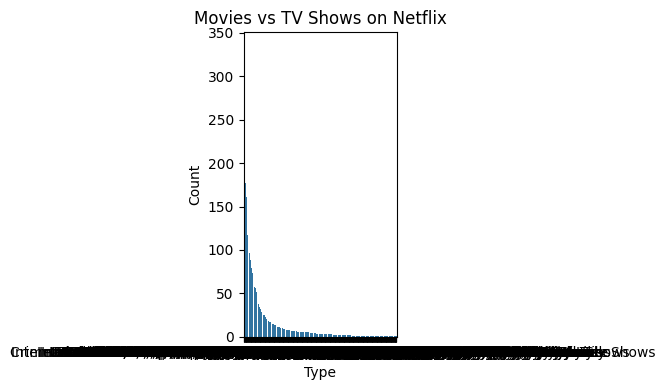

,count
type,
Documentaries,334
Stand-Up Comedy,321
"Dramas, International Movies",320
"Comedies, Dramas, International Movies",243
"Dramas, Independent Movies, International Movies",215
...,...
"Crime TV Shows, International TV Shows, TV Sci-Fi & Fantasy",1
"Docuseries, Science & Nature TV, TV Action & Adventure",1
"British TV Shows, Classic & Cult TV, Kids' TV",1


In [ ]:
plt.figure(figsize=(6,4))
try:
    sns.countplot(data=df, x='type', order=df['type'].value_counts().index)
    plt.title('Movies vs TV Shows on Netflix')
    plt.xlabel('Type')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()
    display(df['type'].value_counts(dropna=False))
except Exception as e:
    print('Could not plot Movies vs TV Shows distribution:', e)


## 📅 Content Added Over Time (Yearly)

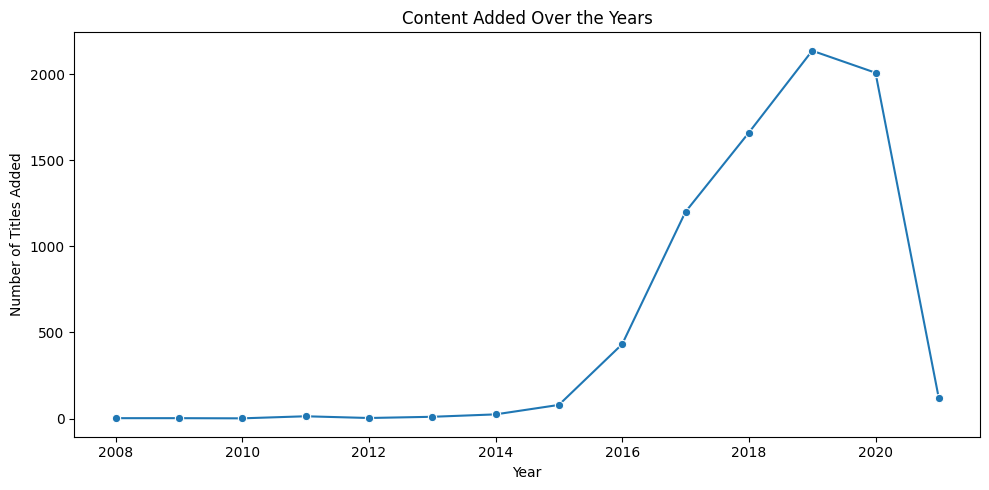

,count
year_added,
2008.0,2
2009.0,2
2010.0,1
2011.0,13
2012.0,3
2013.0,10
2014.0,24
2015.0,79
2016.0,432


In [ ]:
if 'year_added' in df.columns and df['year_added'].notnull().any():
    yearly = df['year_added'].value_counts().sort_index()
    plt.figure(figsize=(10,5))
    sns.lineplot(x=yearly.index, y=yearly.values, marker='o')
    plt.title('Content Added Over the Years')
    plt.xlabel('Year')
    plt.ylabel('Number of Titles Added')
    plt.tight_layout()
    plt.show()
    display(yearly)
else:
    print('Year information not available — skipping yearly trend plot.')


## 🌍 Top Countries by Content Count

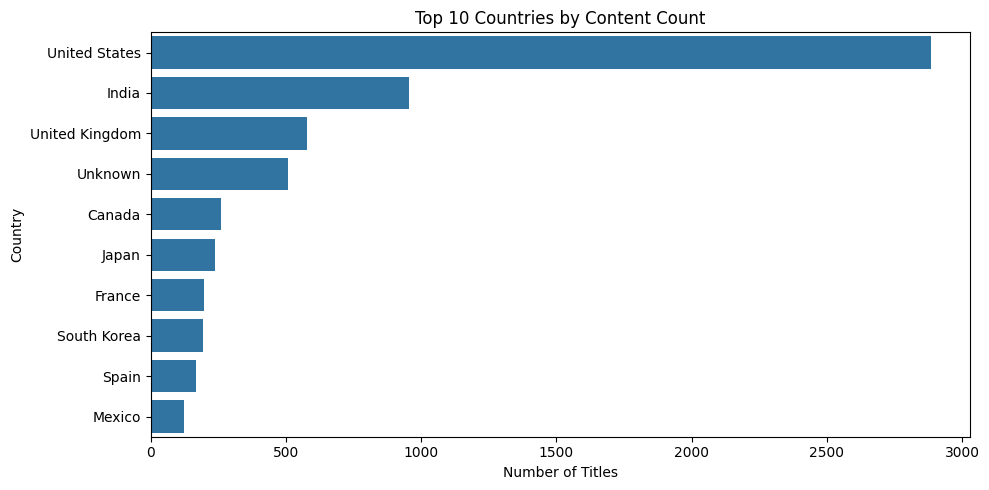

,count
country,
United States,2884
India,956
United Kingdom,577
Unknown,507
Canada,259
Japan,237
France,196
South Korea,194
Spain,168


In [ ]:
try:
    top_countries = df['country'].value_counts().head(10)
    plt.figure(figsize=(10,5))
    sns.barplot(x=top_countries.values, y=top_countries.index)
    plt.title('Top 10 Countries by Content Count')
    plt.xlabel('Number of Titles')
    plt.ylabel('Country')
    plt.tight_layout()
    plt.show()
    display(top_countries)
except Exception as e:
    print('Could not compute country distribution:', e)


## 🎭 Top Genres

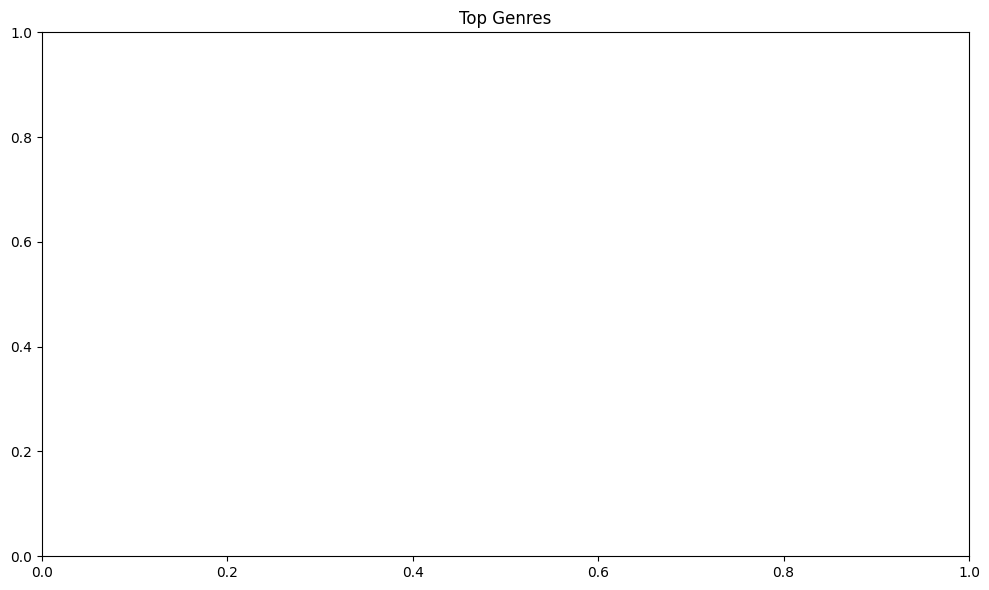

,Genre,Count


In [ ]:
try:
    genre_counts = Counter()
    for gl in df['genre_list']:
        for g in gl:
            genre_counts[g] += 1
    top_genres = pd.DataFrame(genre_counts.most_common(15), columns=['Genre','Count'])
    plt.figure(figsize=(10,6))
    sns.barplot(data=top_genres, x='Count', y='Genre')
    plt.title('Top Genres')
    plt.tight_layout()
    plt.show()
    display(top_genres)
except Exception as e:
    print('Could not compute genres:', e)


## 🔍 Insights & Strategic Recommendations
The observations below are generic — re-run the notebook and inspect outputs (the printed tables and plots) to tailor final recommendations.

In [ ]:
print('--- Strategic Insights (automatically generated) ---')
# Simple automatic insights based on available data
try:
    total = len(df)
    movies = df[df['type'].str.lower()=='movie'].shape[0] if df['type'].notna().any() else None
    tv = df[df['type'].str.lower()=='tv show'].shape[0] if df['type'].notna().any() else None
    if movies is not None and tv is not None:
        print(f'Out of {total} titles: Movies = {movies} ({movies/total:.1%}), TV Shows = {tv} ({tv/total:.1%})')
except Exception:
    pass

# Top country
try:
    top_country = df['country'].value_counts().idxmax()
    print(f'Top contributing country: {top_country}')
except Exception:
    pass

# Top genre
try:
    top_gen = top_genres.iloc[0]['Genre'] if 'top_genres' in globals() and not top_genres.empty else None
    if top_gen:
        print(f'Most frequent genre: {top_gen}')
except Exception:
    pass

print('\n--- Recommendations (generic) ---')
print('1. If a few countries dominate the catalog, consider investing in regional content for diversity.')
print('2. Identify rising genres by comparing year-over-year counts (if year data is available).')
print('3. Keep a balanced slate of Movies and TV Shows to serve both binge-watchers and movie viewers.')


--- Strategic Insights (automatically generated) ---
Out of 7789 titles: Movies = 0 (0.0%), TV Shows = 0 (0.0%)
Top contributing country: United States

--- Recommendations (generic) ---
1. If a few countries dominate the catalog, consider investing in regional content for diversity.
2. Identify rising genres by comparing year-over-year counts (if year data is available).
3. Keep a balanced slate of Movies and TV Shows to serve both binge-watchers and movie viewers.


## ✅ Notes
- If you still see any error, please paste the **exact error message** (red text) here and I will patch the notebook accordingly.
- If your CSV uses a different delimiter (e.g., `;`) re-upload or adjust the `read_csv` call with `sep=';'`.